# Load Shedding, Shifting and Elastic Demand

This example is a simple illustration that aims to explain the use of load shedding, load shifting and elastic demand in PyPSA. The example is designed to simulate a single day of electrical consumption in a small network with solar generation, which could represent a single house or a small group of houses.

In [47]:
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Build example network

First, let's start building a minimal example network for which we demonstrate the demand modelling cases.
The example network is represented as single bus: 
- with one PV generator
- and one baseload electricity demand profile
- between 04:00 - 20:00

In [48]:
network = pypsa.Network()

# Add a bus
network.add("Bus", "My bus")

# Add fuel types
network.add("Carrier", "solar")
network.add("Carrier", "load")

# Add snapshots to define considered time span
network.set_snapshots(pd.date_range("2023-01-01 04:00", "2023-01-01 20:00", freq="H"))

# Add solar generation
pv_pu = [
    0.0,
    0.0,
    0.0,
    0.2,
    0.4,
    0.65,
    0.85,
    0.9,
    0.85,
    0.65,
    0.4,
    0.3,
    0.2,
    0.1,
    0.0,
    0.0,
    0.0,
]

# Add solar generation
network.add(
    "Generator",
    "solar",
    bus="My bus",
    p_nom=0.4,
    carrier="solar",
    p_max_pu=pv_pu,
    marginal_cost=0.01,
)

# Add baseload
load = pd.Series(0.2, index=range(17))  # constant baseload
network.add("Load", "baseload", bus="My bus", p_set=load.values)

Plotting the minimal example network data, we can see that supply **cannot** equal demand at all time steps. This means that a stable grid operation is not possible.

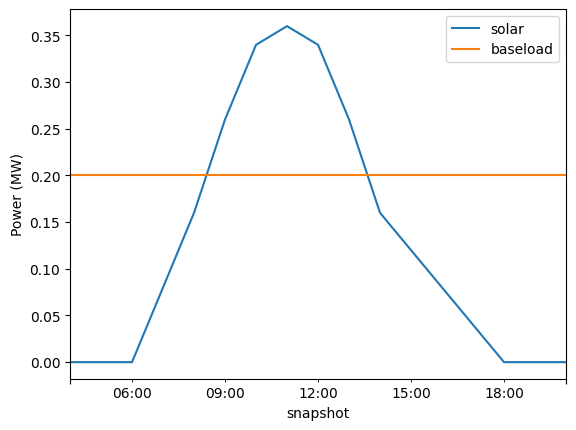

In [49]:
fig, ax = plt.subplots()

(network.generators_t.p_max_pu*network.generators.p_nom).plot(ax=ax)
network.loads_t.p_set.plot(ax=ax)

ax.set_ylabel("Power (MW)")
ax.get_legend().set_title("")

Trying to optimize this network without any possibility of achieving the energy balance at every time step will lead to a infeasible optimization.

In [50]:
network.optimize()

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.01s
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: not available
Solver message: undefined



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-ebqvodtb.lp --output /tmp/linopy-solve-0fqoprzb.sol
Reading problem data from '/tmp/linopy-problem-ebqvodtb.lp'...
51 rows, 17 columns, 51 non-zeros
248 lines were read
GLPK Simplex Optimizer 5.0
51 rows, 17 columns, 51 non-zeros
Preprocessing...
PROBLEM HAS NO PRIMAL FEASIBLE SOLUTION
If you need actual output for non-optimal solution, use --nopresol
Time used:   0.0 secs
Memory used: 0.0 Mb (47725 bytes)
Writing basic solution to '/tmp/linopy-solve-0fqoprzb.sol'...


('warning', 'infeasible_or_unbounded')

## Load shedding

"Load shedding" in power networks often happens under extreme conditions, e.g. to prevent network faults. In models, we consider load shedding as extremely expensive and unconstrained generators that can practically decrease the demand to zero. Tip: Load shedding generators are often used to track-down infeasibilities from power shortages (as above) or too tight constraints.

In [51]:
# Add load shedding as generator
network.add(
    "Generator",
    "load shedding",
    bus="My bus",
    p_nom=50,
    carrier="load",
    marginal_cost=1e2,  # 100 €/MWh
)

After adding load shedding, the optimization will pass as the nodal energy balance is fulfilled

In [52]:
network.optimize()

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34 primals, 85 duals
Objective: 1.76e+02
Solver model: not available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-f5n5t6hv.lp --output /tmp/linopy-solve-d0fxu882.sol
Reading problem data from '/tmp/linopy-problem-f5n5t6hv.lp'...
85 rows, 34 columns, 102 non-zeros
435 lines were read
GLPK Simplex Optimizer 5.0
85 rows, 34 columns, 102 non-zeros
Preprocessing...
~     0: obj =   1.760164000e+02  infeas =  0.000e+00
OPTIMAL SOLUTION FOUND BY LP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.1 Mb (64484 bytes)
Writing basic solution to '/tmp/linopy-solve-d0fxu882.sol'...


('ok', 'optimal')

Looking at the optimization results, the mismatch is exactly compensated by load shedding.

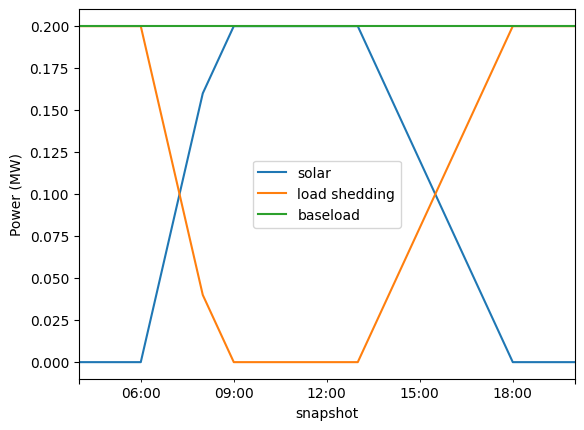

In [53]:
fig, ax = plt.subplots()

network.generators_t.p.plot(ax=ax)
network.loads_t.p.plot(ax=ax)

ax.set_ylabel("Power (MW)")
ax.get_legend().set_title("")

## Load shifting

"Load shifting" is often used to provide system benefits arising from demand side flexibility. Benfits can arise from shifting elecitricy from peak to off-peak hours e.g. with electric vehicles, data center, and many more. Below we implement smart thermostats that can shift **electric** heating demand from one to another period.

For simplicity, we use for the load shifting implementation the PyPSA `StorageUnit` component. Another [example](https://github.com/PyPSA/247-cfe/blob/b4a1196537babb219ca9f22e3b836d7f89ae5b56/scripts/solve_network.py#L631-L684) exist using the PyPSA `Store`, `Link` and `Generator` components. 

In [54]:
# add battery as carrier
network.add("Carrier", "thermostat")

# add smart thermostat as storage unit
network.add(
    "StorageUnit",
    "smart thermostat",
    bus="My bus",
    p_nom=0,
    carrier="heat",
    p_nom_extendable=True,
    standing_loss=0.01,  # penalize if load shifting is not applied at the first instance of mismatch
    cyclic_state_of_charge=True,
    max_hours=6,
)

### Let's solve and plot load shifting and shedding 

In [55]:
network.optimize()

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 86 primals, 205 duals
Objective: 1.23e+02
Solver model: not available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-vn7hikd0.lp --output /tmp/linopy-solve-2qurzbof.sol
Reading problem data from '/tmp/linopy-problem-vn7hikd0.lp'...
205 rows, 86 columns, 358 non-zeros
1095 lines were read
GLPK Simplex Optimizer 5.0
205 rows, 86 columns, 358 non-zeros
Preprocessing...
85 rows, 63 columns, 215 non-zeros
Scaling...
 A: min|aij| =  9.900e-01  max|aij| =  6.000e+00  ratio =  6.061e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 85
      0: obj =   1.200220000e+02 inf =   5.600e-01 (6)
      6: obj =   1.760164000e+02 inf =   0.000e+00 (0)
*    25: obj =   1.230287389e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.2 Mb (182941 bytes)
Writing basic solution to '/tmp/linopy-solve-2qurzbof.sol'...


('ok', 'optimal')

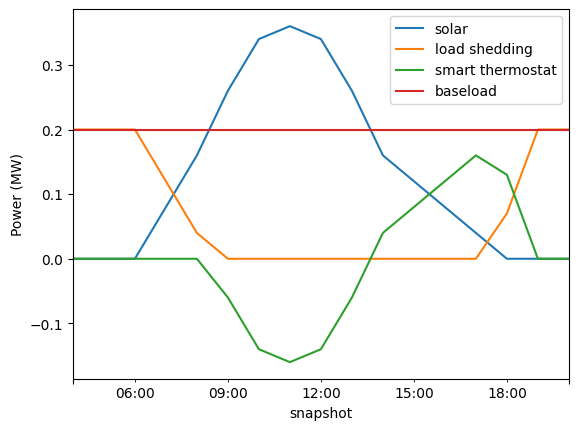

In [56]:
fig, ax = plt.subplots()

network.generators_t.p.plot(ax=ax)
network.storage_units_t.p.plot(ax=ax)
network.loads_t.p.plot(ax=ax)

ax.set_ylabel("Power (MW)")
ax.get_legend().set_title("")

We can observe from the least cost solution the following:
- The smart thermostat is increasing the demand during the peak solar generation, to save energy when there is a lack of supply
- In the first and last hours of the day, load shedding is applied since there is not enough storage or generation available

## Elastic Demand

Demand is slightly "elastic", meaning consumers would use less energy if its too expensive, or would use more energy if its low costs. Think about yourself. Would you consume less energy if its 5 times more expensive than today? The elasticity of demand is usually nonlinear and highly depended on individuals. If you are interested to read more into this, [Labandeira et al. (2017)](https://doi.org/10.1016/j.enpol.2017.01.002) surveys 428 papers that use various econometric techniques to evaluate energy demand elasticity to price.

We model elastic demand by:
  - Quadratic programming implementation which avoids a sequential approach (see [here](https://github.com/PyPSA/PyPSA/issues/574))

In [57]:
network.remove("Generator", "load shedding")
network.remove("StorageUnit", "smart thermostat")

In [58]:
elastic_intercept = 20 # change here to alter level of price elasticity
network.add(
    "Generator",
    "load reduction because of price elasticity",
    bus="My bus",
    p_nom=50,
    carrier="load",
    marginal_cost_quadratic=(elastic_intercept / (2 * load)).values,  # series of 50 €/MWh
)

# add baseload generator
network.add(
    "Generator",
    "baseload generator",
    bus="My bus",
    p_nom=0.3,
    carrier="gas",
    marginal_cost_quadratic=100 # 100 €/MWh  # QP formulation requires everywhere use of quadratic cost
)

network.optimize(solver_name="highs")  # QP requires highs instead of default glpk

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 51 primals, 119 duals
Objective: 1.01e+01
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
0, 24.010000, 0, 0.000305, 0.000000, 0, 0.000000, 0.000000
69, 10.149730, 22, 0.000657, 0.000000, 0, 0.000000, 0.086957
Model   status      : Optimal
QP ASM    iterations: 69
Objective value     :  1.0149729583e+01
HiGHS run time      :          0.00


('ok', 'optimal')

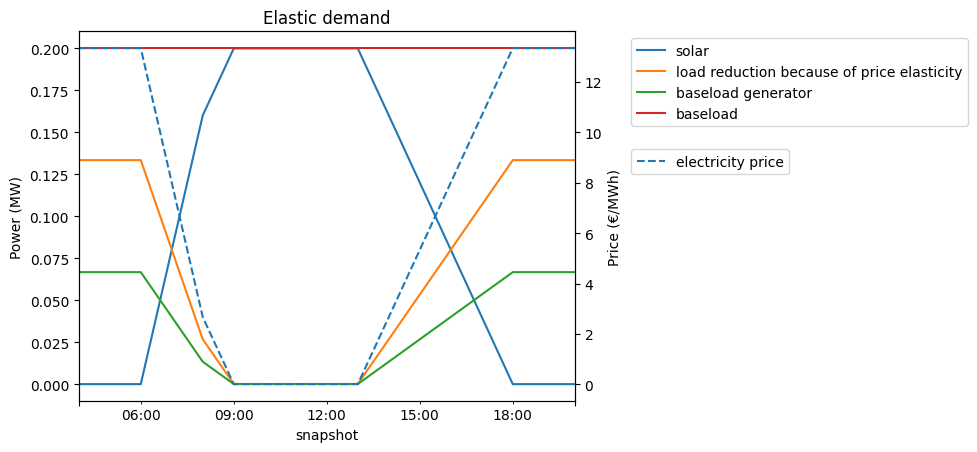

In [59]:
fig, ax = plt.subplots()
network.generators_t.p.plot(ax=ax)
network.loads_t.p.plot(ax=ax)
ax2 = ax.twinx()
network.buses_t.marginal_price.rename(columns={"My bus": "electricity price"}).plot(ax=ax2, linestyle="--")
ax.set_title("Elastic demand")
ax.set_ylabel("Power (MW)")
ax.get_legend().set_title("")
ax.legend(bbox_to_anchor=(1.1, 1))
ax2.set_ylabel("Price (€/MWh)")
ax2.legend(bbox_to_anchor=(1.1, 0.7))

We can observe from the elastic demand the following:
- The load reduction is higher the higher the shadow prices are (= elastic demand)